In [2]:
import os
import sys
from pathlib import Path

SRC_PATH = Path(__name__).resolve().parents[1]

sys.path.append(str(SRC_PATH))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


In [3]:
SRC_PATH

PosixPath('/mnt/c/Users/Moon/OneDrive/CS/Project/PMU_detection')

In [ ]:
from data_generator.pmu import VirtualPMU
from src.preprocess import MissingHandler

In [4]:
pmu = pd.read_csv("../data/pmu.csv")

In [6]:
pmu.head()

,timestamp,frequency,voltage,current,phase_angle,anomaly_type,anomaly_class
0,2024-09-30 13:42:02.470688,60.000000,1.000000,0.950000,0.014385,Normal,0
1,2024-09-30 13:42:03.470688,59.999950,0.999800,0.950419,0.056260,Normal,0
2,2024-09-30 13:42:04.470688,59.999900,0.999599,0.950838,0.098063,Normal,0
3,2024-09-30 13:42:05.470688,59.999849,0.999399,0.951256,0.139718,Normal,0
4,2024-09-30 13:42:06.470688,59.999799,0.999199,0.951673,0.181154,Normal,0


In [16]:
class RoCoFDetector:
    @staticmethod
    def calculate_rocof(frequency):
        rocof = np.diff(frequency, prepend=frequency[0])  # Rate of Change of Frequency
        return rocof
    def detect(self, rocof, threshold=0.125):
        
        anomalies = np.abs(rocof) > threshold
        return anomalies

In [23]:
class TKEODetector:
    def detect(self, signal, threshold=0.05):
        teager = self.teager_kaiser_energy_operator(signal)
        anomalies = teager > threshold
        return anomalies

    @staticmethod
    def teager_kaiser_energy_operator(signal):
        teager = np.zeros(len(signal))
        teager[1:-1] = signal[1:-1]**2 - signal[0:-2] * signal[2:]
        return teager

In [35]:
from scipy.stats import zscore

# Z-Score Detector
class ZscoreDetector:
    def detect(self, data_frame, col_list:list, threshold=3):
        z_scores = np.abs(zscore(data_frame[col_list], nan_policy='omit'))
        anomalies = (z_scores > threshold).any(axis=1)
        return anomalies

In [13]:
pmu["rocof"] = RoCoFDetector.calculate_rocof(pmu["frequency"])

In [17]:
rocof_detector = RoCoFDetector()

In [45]:
rocof_anomalies = rocof_detector.detect(pmu["rocof"], threshold=0.125)

In [46]:
confusion_matrix(pmu["anomaly_class"], rocof_anomalies)

array([[59884,    88],
       [   20,     8]])

In [24]:
tkeo_detector = TKEODetector()

In [27]:
fre_tkeo_anomalies = tkeo_detector.detect(pmu["frequency"].values)
vol_tkeo_anomalies = tkeo_detector.detect(pmu["voltage"].values)
curr_tkeo_anomalies = tkeo_detector.detect(pmu["current"].values)
phase_tkeo_anomalies = tkeo_detector.detect(pmu["phase_angle"].values)


In [29]:
confusion_matrix(pmu["anomaly_class"], fre_tkeo_anomalies)

array([[59874,    98],
       [   24,     4]])

In [30]:
confusion_matrix(pmu["anomaly_class"], vol_tkeo_anomalies)

array([[59964,     8],
       [   26,     2]])

In [31]:
confusion_matrix(pmu["anomaly_class"], curr_tkeo_anomalies)

array([[59972,     0],
       [   28,     0]])

In [32]:
confusion_matrix(pmu["anomaly_class"], phase_tkeo_anomalies)

array([[59960,    12],
       [   25,     3]])

In [33]:
combined_anomalies = fre_tkeo_anomalies | vol_tkeo_anomalies | curr_tkeo_anomalies | phase_tkeo_anomalies

In [34]:
confusion_matrix(pmu["anomaly_class"], combined_anomalies)

array([[59854,   118],
       [   19,     9]])

In [36]:
z_score_list = ['frequency', 'voltage', 'current', 'phase_angle']

z_score_detector = ZscoreDetector()

In [43]:
z_score_anomalies = z_score_detector.detect(pmu, col_list=z_score_list, threshold=3.5)

In [44]:
confusion_matrix(pmu["anomaly_class"], z_score_anomalies)

array([[59748,   224],
       [   15,    13]])

In [47]:
full_anomalies = combined_anomalies | z_score_anomalies | rocof_anomalies

confusion_matrix(pmu["anomaly_class"], full_anomalies)

array([[59670,   302],
       [   10,    18]])

In [48]:
f1_score(pmu["anomaly_class"], full_anomalies)

0.10344827586206896

In [49]:
accuracy_score(pmu["anomaly_class"], full_anomalies)

0.9948

In [50]:
precision_score(pmu["anomaly_class"], full_anomalies)

0.05625

In [51]:
recall_score(pmu["anomaly_class"], full_anomalies)

0.6428571428571429

In [52]:
# Drop the timestamp column and normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pmu[['frequency', 'voltage', 'current', 'phase_angle']])


In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Fit KMeans to the PMU data (scaled)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data)

# Calculate the distance of each point to its closest cluster centroid
_, distances = pairwise_distances_argmin_min(kmeans.cluster_centers_, scaled_data)

# Set a threshold based on the 90th percentile of the distances
kmeans_threshold = np.percentile(distances, 90)

# Detect anomalies
kmeans_anomalies = distances > kmeans_threshold

In [67]:
kmeans_anomalies = kmeans.transform(scaled_data).argmax(axis=1)

In [68]:
confusion_matrix(pmu["anomaly_class"], kmeans_anomalies)

array([[29914, 30058],
       [    9,    19]])

In [69]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN to the PMU data
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(scaled_data)

# In DBSCAN, points with label -1 are anomalies
dbscan_anomalies = dbscan.labels_ == 1

confusion_matrix(pmu["anomaly_class"], dbscan_anomalies)

array([[59963,     9],
       [   27,     1]])

In [70]:
# 
from sklearn.ensemble import IsolationForest

# Isolation forest 
outliers_fraction = 0.01
ifo = IsolationForest(contamination = outliers_fraction)

ifo.fit(scaled_data)

ifo_anomailes = ifo.predict(scaled_data)

In [81]:
np.unique(ifo_anomailes)
iifo_anomailes = np.where(ifo_anomailes == -1, 1, 0)

In [82]:
confusion_matrix(pmu["anomaly_class"], iifo_anomailes)

array([[59382,   590],
       [   18,    10]])

In [83]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')


2024-09-30 14:38:51.612791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 14:38:51.612953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 14:38:51.730871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 14:38:51.983919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 14:38:57.216125: W tensorflow/comp

In [84]:
pmu.head()

,timestamp,frequency,voltage,current,phase_angle,anomaly_type,anomaly_class,rocof,rocof_anomalies
0,2024-09-30 13:42:02.470688,60.000000,1.000000,0.950000,0.014385,Normal,0,0.00000,False
1,2024-09-30 13:42:03.470688,59.999950,0.999800,0.950419,0.056260,Normal,0,-0.00005,False
2,2024-09-30 13:42:04.470688,59.999900,0.999599,0.950838,0.098063,Normal,0,-0.00005,False
3,2024-09-30 13:42:05.470688,59.999849,0.999399,0.951256,0.139718,Normal,0,-0.00005,False
4,2024-09-30 13:42:06.470688,59.999799,0.999199,0.951673,0.181154,Normal,0,-0.00005,False


In [87]:
#separate the data and labels so that it will be easy for understanding
data = pmu[["frequency", "voltage", "current", "phase_angle", "rocof"]].values
labels = pmu[["anomaly_class"]].values


In [114]:
pmu["anomaly_class"].value_counts()

anomaly_class
0    59972
1       28
Name: count, dtype: int64

In [188]:
timestep = 120
overlap = 1

# 데이터에 윈도우 적용
data_window = [data[i:i + timestep] for i in range(0, data.shape[0] - timestep + 1, overlap)]
data_window_array = np.array(data_window)

# 라벨에 윈도우 적용
label_window = [labels[i:i + timestep] for i in range(0, labels.shape[0] - timestep + 1, overlap)]

# 각 윈도우의 라벨을 결정
label_window_array = []
for window in label_window:
    if 1 in window:  # 윈도우 안에 1이 있는지 확인
        label_window_array.append(1)
    else:
        label_window_array.append(np.argmax(np.bincount(window.flatten())))

label_window_array = np.array(label_window_array)

# 결과 확인
print("Data window shape:", data_window_array.shape)
print("Label window shape:", label_window_array.shape)

Data window shape: (59881, 120, 5)
Label window shape: (59881,)


In [189]:
labeled_data = data_window_array[np.where(label_window_array > 0)]

In [206]:
np.where(label_window_array > 0)

(array([  328,   329,   330, ..., 59222, 59223, 59224]),)

In [190]:
labeled_data.shape

(3359, 120, 5)

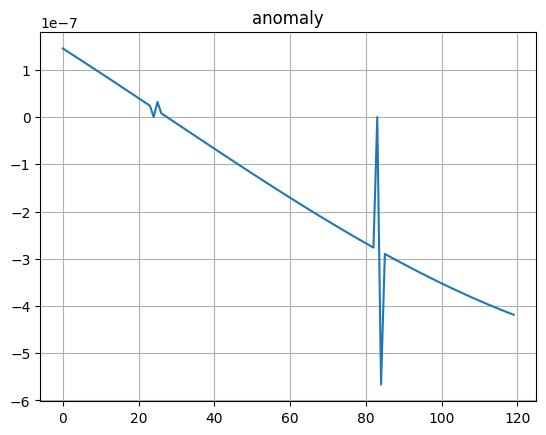

In [212]:
plt.plot(np.arange(timestep), data_window_array[59223][:, 4])
plt.grid()
plt.title('anomaly')
plt.show()

In [213]:
pmu

,timestamp,frequency,voltage,current,phase_angle,anomaly_type,anomaly_class,rocof,rocof_anomalies
0,2024-09-30 13:42:02.470688,60.000000,1.000000,0.950000,0.014385,Normal,0,0.000000,False
1,2024-09-30 13:42:03.470688,59.999950,0.999800,0.950419,0.056260,Normal,0,-0.000050,False
2,2024-09-30 13:42:04.470688,59.999900,0.999599,0.950838,0.098063,Normal,0,-0.000050,False
3,2024-09-30 13:42:05.470688,59.999849,0.999399,0.951256,0.139718,Normal,0,-0.000050,False
4,2024-09-30 13:42:06.470688,59.999799,0.999199,0.951673,0.181154,Normal,0,-0.000050,False
...,...,...,...,...,...,...,...,...,...
59995,2024-09-30 13:51:58.169206,60.000223,1.000094,0.948255,-0.193799,Normal,0,-0.000045,False
59996,2024-09-30 13:51:59.169206,60.000179,1.000094,0.948602,-0.152656,Normal,0,-0.000045,False
59997,2024-09-30 13:52:00.169206,60.000134,1.000056,0.948950,-0.111221,Normal,0,-0.000045,False
59998,2024-09-30 13:52:01.169206,60.000089,1.000038,0.949300,-0.069565,Normal,0,-0.000045,False


In [214]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pmu[['frequency', 'voltage', 'current', 'phase_angle']])

# 정상 상태 데이터만 사용하여 오토인코더 학습
normal_data = scaled_data[pmu['anomaly_class'] == 0]

# 오토인코더 모델 정의
def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(32, activation='relu')(input_layer)
    encoded = layers.Dense(16, activation='relu')(encoded)
    encoded = layers.Dense(8, activation='relu')(encoded)
    
    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(32, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = tf.keras.models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [215]:
# 모델 학습
input_dim = normal_data.shape[1]
autoencoder = build_autoencoder(input_dim)
autoencoder.fit(normal_data, normal_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)


2024-09-30 15:09:40.910315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:b3:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-30 15:09:41.376450: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
1500/1500 [==============================] - 8s 4ms/step - loss: 0.1401 - val_loss: 0.0038
Epoch 2/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0059 - val_loss: 0.0182
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 5/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 8/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0038 - val_loss: 0.0067
Epoch 9/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0034 - val_loss: 6.5727e-04
Epoch 10/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0

In [220]:
# 모든 데이터에 대해 재구성 오류 계산
reconstructed_data = autoencoder.predict(scaled_data)
reconstruction_error = np.mean(np.abs(reconstructed_data - scaled_data), axis=1)

# 이상 탐지 기준: 재구성 오류가 일정 임계값 이상이면 이상으로 간주
threshold = np.percentile(reconstruction_error[pmu['anomaly_class'] == 0], 99)  # 상위 5%를 임계값으로 설정
predictions = (reconstruction_error > threshold).astype(int)

# 성능 평가
f1 = f1_score(pmu['anomaly_class'], predictions)
precision = precision_score(pmu['anomaly_class'], predictions)
recall = recall_score(pmu['anomaly_class'], predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

1875/1875 [==============================] - 3s 2ms/step
F1 Score: 0.0497
Precision: 0.0260
Recall: 0.5714


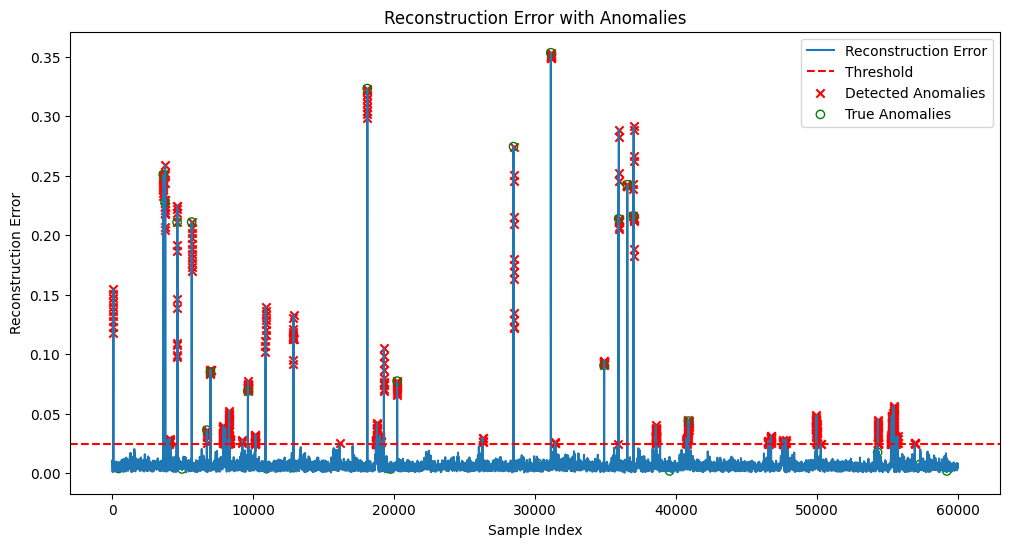

In [221]:
# 재구성 오류 시각화
def visualize_reconstruction_error(reconstruction_error, predictions, anomaly_class, threshold):
    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_error, label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    
    # 이상 탐지된 부분 표시
    anomaly_idx = np.where(predictions == 1)[0]
    plt.scatter(anomaly_idx, reconstruction_error[anomaly_idx], color='red', label='Detected Anomalies', marker='x')
    
    # 실제 이상이 발생한 부분 표시
    real_anomalies_idx = np.where(anomaly_class == 1)[0]
    plt.scatter(real_anomalies_idx, reconstruction_error[real_anomalies_idx], color='green', label='True Anomalies', marker='o', facecolors='none')
    
    plt.title('Reconstruction Error with Anomalies')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.show()

# 재구성 오류 및 이상 탐지 결과 시각화
visualize_reconstruction_error(reconstruction_error, predictions, pmu['anomaly_class'].values, threshold)